# Task 4: Multi-product Highly Non-Stationary Pricing

Notebook with:
- Multi-product highly non-stationary environment (correlated valuations)
- Primal–Dual agent with one Hedge learner per product (fixed price grid)
- Clairvoyant baseline (best fixed price vector in hindsight, chronological acceptance until inventory P)
- Regret computation and plots aggregated over multiple simulations
- NB: the inventory P is shared among the different types of product


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
import itertools
plt.rcParams['figure.figsize'] = (16, 9)
np.random.seed(42)
import sys

sys.path.append('../utils')
from Hedge import HedgeAgent
from EXP3_P import Exp3Agent

from Multi_Primal_Dual import  MultiProductPrimalDualAgent

## Environment Setup

In [5]:
class HighlyNonStatMultiProductPricingEnvironment:
    """
    Multi-product highly non-stationary environment for dynamic pricing with inventory constraint.

    This environment simulates a multi-product pricing scenario where:
    - Each product has its own customer valuation distribution
    - These distributions change every round (changing mean and std for non-stationarity)
    - Customers have different preferences for different products
    - Each round represents one customer interaction
    - The customer can purchase multiple products or none at all
    """

    def __init__(self, valuation_dists, prices_grid, demand_noise_std=0.0):
        """
        Initialize the multi-product pricing environment.

        Args:
            valuation_dists: List of mvn distributions for each round
            prices_grid : Fixed grid of possible discretized prices (dimensions: n_products x K)
            demand_noise_std: Std of optional gaussian noise on valuations
        """
        self.valuation_dists = valuation_dists
        self.T = len(valuation_dists)
        self.n_products = prices_grid.shape[0]
        self.prices_grid = prices_grid
        self.current_round = 0
        self.noise_std = demand_noise_std

    def simulate_round(self, price_vector, offered_mask=None):
        """
        Simulate one customer interaction for a given product subset and prices.

        Args:
            price_vector: Array of prices for each product
            offered_mask: List of product indices being offered (if None, all products are offered)

        Returns:
            tuple: (purchases, total_revenue, per_product_revenue, valuations) where:
                - purchases: List of products actually purchased
                - total_revenue: Sum of revenues from purchased products
                - per_product_revenue: Array of revenue for each product
                - valuations: Exact valuations for each product (array of length n_products) at current round (one vector for each round)
        """
        if offered_mask is None:
            offered_mask = np.ones(self.n_products, dtype=bool)
        
        idx = min(self.current_round, self.T - 1)
        mvn = self.valuation_dists[idx]
        valuations = np.atleast_1d(mvn.rvs())
        if self.noise_std > 0:
            valuations = valuations + np.random.normal(0.0, self.noise_std, size=self.n_products)
        
        purchases = (offered_mask & (valuations >= price_vector)).astype(int)
        per_product_revenue = purchases * price_vector
        total_revenue = float(per_product_revenue.sum())
        
        self.current_round += 1

        return purchases, total_revenue, per_product_revenue, valuations


## Time-Varying Valuations

In [6]:
def build_time_varying_mvn_list(T, n_products, base_corr=0.5, mean_range=(0.4, 0.6), std_range=(0.1, 0.2), seed=0):
    """
    Build a sequence of time-varying multivariate normal (MVN) distributions
    representing correlated valuations for multiple products.

    The generated environment is highly non-stationary:
    - At each time step `t`, a new MVN is defined over all products.
    - Product means evolve over time with autocorrelation and random shocks.
    - Standard deviations vary per product and per time step.
    - A fixed correlation structure (base_corr) is applied across products,
      adjusted to ensure the covariance matrix is positive semi-definite (PSD).

    Args:
        T (int): Number of time steps (rounds) to simulate
        n_products (int): Number of products (dimensions in MVN)
        base_corr (float, optional): Base correlation between products, in [-1, 1]
                                     Defaults to 0.5
        mean_range (tuple of float, optional): Minimum and maximum mean values
                                               for product valuations. Defaults to (0.2, 1.0)
        std_range (tuple of float, optional): Minimum and maximum standard deviations
                                              for product valuations. Defaults to (0.05, 0.25)
        seed (int, optional): Random seed for reproducibility. Defaults to 0

    Returns:
        list of scipy.stats._multivariate.multivariate_normal_frozen:
            A list of length T, where each element is a frozen MVN distribution
            (mean vector and covariance matrix) for that time step

    Notes:
        - Means evolve as: mean_t = 0.4 * mean_{t-1} + 0.6 * (mean_t + shock_t),
          clipped to `mean_range`
        - Shocks are Gaussian noise with mean 0 and std 0.5
        - Covariance matrices are built as D * R * D, where:
            - D = diagonal matrix of stds for that time step
            - R = constant correlation matrix adjusted if needed for PSD
        - `allow_singular=True` is used to handle near-singular covariances
    """
    rng = np.random.default_rng(seed)

    # Build base correlation matrix
    R = np.full((n_products, n_products), base_corr, dtype=float)
    np.fill_diagonal(R, 1.0)

    # Ensure positive semi-definiteness
    eigvals = np.linalg.eigvalsh(R)
    if eigvals.min() < 1e-6:
        alpha = 0.9
        R = alpha * R + (1 - alpha) * np.eye(n_products)

    # Initialize evolving means
    means = rng.uniform(mean_range[0], mean_range[1], size=(T, n_products))
    shocks = rng.normal(0.0, 0.5, size=(T, n_products))
    for t in range(1, T):
        means[t] = np.clip(0.4 * means[t-1] + 0.6 * (means[t] + shocks[t]), mean_range[0], mean_range[1])
    
    # Standard deviations per product per time step
    stds = rng.uniform(std_range[0], std_range[1], size=(T, n_products))

    # Build time-varying MVN distributions
    dists = []
    for t in range(T):
        D = np.diag(stds[t])
        cov = D @ R @ D
        dists.append(multivariate_normal(mean=means[t], cov=cov, allow_singular=True))
    
    return dists


## Simulation

In [7]:
def run_one_simulation(T, n_products, prices_per_product, inventory_frac=0.1, eta=0.5, seed=42, lambda_init_mode='mid', algorithm='Exp3'):
    """
    Run a single simulation of the highly non-stationary multi-product pricing environment 
    with inventory constraints using the MultiProductPrimalDualAgent.

    Workflow:
    1. Build the price grid for each product (same prices for all products)
    2. Generate time-varying correlated valuation distributions for each round
    3. Set inventory level P based on the inventory fraction of the time horizon
    4. Initialize the environment and the primal-dual pricing agent
    5. For each round:
        a. Agent selects prices via primal-dual Hedge learners
        b. If inventory is available, environment simulates purchases and revenues
        c. Agent updates internal weights and Lagrange multiplier based on rewards and inventory usage
        d. Track valuations, per-round revenue, and cumulative revenue
    6. Return full simulation results, including agent, environment, revenue history, and inventory stats
    """
    price_grid_1d = np.linspace(0.2, 0.8, prices_per_product)
    prices_grid = np.tile(price_grid_1d, (n_products, 1))

    valuation_dists = build_time_varying_mvn_list(T, n_products, seed=seed)

    P = int(T * inventory_frac) # Set total inventory P as a fraction of T

    if lambda_init_mode == 'max':
        lambda_init = 1.0 / max(P / float(T), 1e-9)
    elif lambda_init_mode == 'mid':
        lambda_init = 0.5 / max(P / float(T), 1e-9)
    else:
        lambda_init = None

    env = HighlyNonStatMultiProductPricingEnvironment(valuation_dists, prices_grid)
    agent = MultiProductPrimalDualAgent(prices_grid=prices_grid, T=T, P=P, eta=eta, 
                                      lambda_init=lambda_init, algorithm=algorithm)
    
    total_revenue = 0.0
    first_empty = None
    valuations_history = np.zeros((T, n_products))
    revenue_per_round = np.zeros(T)
    cumulative_revenue = np.zeros(T)

    # Main simulation loop
    for t in range(T):

        # Record the first round when inventory runs out
        if agent.remaining_inventory <= 0 and first_empty is None:
            first_empty = t

        # Agent selects prices via the primal-dual Hedge learners
        price_vec = agent.bid()

        # If inventory is depleted, there are no purchases or revenue
        if agent.remaining_inventory <= 0:
            purchases = np.zeros(n_products, dtype=int)
            per_prod_revenue = np.zeros(n_products, dtype=float)
            valuations = np.zeros(n_products)
        else:
            # Simulate the round: purchases, revenue, and realized valuations
            purchases, _, per_prod_revenue, valuations = env.simulate_round(price_vec)
        
        # Store valuations and update the agent
        valuations_history[t] = valuations
        agent.update(purchases, per_prod_revenue, valuations)

        # Update revenue metrics
        total_revenue += float(per_prod_revenue.sum())
        revenue_per_round[t] = float(per_prod_revenue.sum())
        cumulative_revenue[t] = total_revenue
        
    return {
        'agent': agent,
        'env': env,
        'total_revenue': total_revenue,
        'first_inventory_empty': first_empty,
        'P': P,
        'price_grid_1d': price_grid_1d,
        'valuations_history': valuations_history,
        'revenue_per_round': revenue_per_round,
        'cumulative_revenue': cumulative_revenue
    }


In [8]:
def run_simulations(n_sims, T, n_products, prices_per_product, inventory_frac=0.1, eta=0.5, seed=0, lambda_init_mode='mid', algorithm='Exp3'):
    """
    Run multiple independent simulations of the multi-product pricing setup.

    Workflow:
    1. For each simulation index:
        a. Call `run_one_simulation` with a different random seed for stochastic variability
    2. Aggregate and return all simulation outputs in a list
    """
    sims = []
    for s in range(n_sims):
        sims.append(run_one_simulation(T=T, n_products=n_products, prices_per_product=prices_per_product,
                                       inventory_frac=inventory_frac, eta=eta, seed=seed + s, lambda_init_mode=lambda_init_mode, algorithm=algorithm))
    
    return sims


## Baseline Definition

In [9]:
def compute_clairvoyant_from_valuations(valuations_history, price_grid_1d, P):
    """
    Compute the clairvoyant (offline optimal) pricing strategy given realized valuations.

    This function exhaustively searches over all possible price combinations for the products
    to find the combination that would have maximized revenue, assuming perfect knowledge
    of future valuations.

    Key improvements:
    - When demand exceeds inventory, prioritizes highest-revenue products
    - Proper handling of inventory constraints
    - Optimized acceptance logic for maximum revenue

    Args:
        valuations_history (np.ndarray): T x n_products array of realized valuations for each round.
        price_grid_1d (np.ndarray): Array of available discrete prices for each product.
        P (int): Total inventory available (shared across products).

    Returns:
        best_combo (np.ndarray): The price combination per product that yields maximum revenue.
        best_cum (np.ndarray): Cumulative revenue over time when using this price combination.
    """
    T, n_products = valuations_history.shape
    K = len(price_grid_1d)

    best_total = -1.0
    best_cum = np.zeros(T)
    best_combo = None

    # Iterate over all possible price combinations (cartesian product)
    for combo in itertools.product(range(K), repeat=n_products):
        prices = np.array([price_grid_1d[c] for c in combo])
        
        # Pre-compute which products would be purchased at these prices
        purchases_matrix = (valuations_history >= prices).astype(int)

        remaining = P       # Track remaining inventory
        cum = np.zeros(T)   # Track cumulative revenue per round
        total = 0.0         # Total revenue

        for t in range(T):
            if remaining <= 0:
                # No inventory left; all future revenue is zero
                cum[t:] = total
                break

            sold = purchases_matrix[t]
            willing_to_buy = np.where(sold == 1)[0]  # Indices of products customer wants
            n_willing = len(willing_to_buy)

            if n_willing == 0:
                # No sales this round
                cum[t] = total
                continue

            # Determine how many units we can actually sell
            units_to_sell = min(remaining, n_willing)
            
            if units_to_sell == n_willing:
                # Can sell everything customer wants
                accepted_products = willing_to_buy
            else:
                # Must choose which products to sell - choose highest revenue ones
                product_revenues = prices[willing_to_buy]
                # Sort by revenue (descending) and take top 'units_to_sell'
                sorted_indices = np.argsort(product_revenues)[::-1]
                accepted_products = willing_to_buy[sorted_indices[:units_to_sell]]

            # Compute revenue for this round
            revenue_t = prices[accepted_products].sum()
            total += revenue_t
            remaining -= len(accepted_products)
            cum[t] = total

        # Update the best combination if this one is better
        if total > best_total:
            best_total = total
            best_cum = cum.copy()
            best_combo = prices.copy()
            
    return best_combo, best_cum


In [10]:
def compute_clairvoyant_efficient(valuations_history, price_grid_1d, P):
    """
    Efficient clairvoyant computation using dynamic programming approach.
    
    Instead of exhaustively searching all K^n combinations, this approach:
    1. For each round, finds the optimal price-quantity allocation given remaining inventory
    2. Uses a greedy approach: at each round, choose prices that maximize immediate revenue
       while considering the inventory constraint
    
    This is much faster: O(T × K × n) instead of O(K^n × T)
    Note: This gives an upper bound but may not be the true optimum due to the greedy nature.
    
    Args:
        valuations_history (np.ndarray): T x n_products array of realized valuations
        price_grid_1d (np.ndarray): Array of available discrete prices
        P (int): Total inventory available
        
    Returns:
        best_combo (np.ndarray): Average price combination used
        best_cum (np.ndarray): Cumulative revenue over time
    """
    T, n_products = valuations_history.shape
    K = len(price_grid_1d)
    
    remaining = P
    cum_revenue = np.zeros(T)
    total_revenue = 0.0
    price_usage = np.zeros((n_products, K))  # Track which prices were used how often
    
    for t in range(T):
        if remaining <= 0:
            cum_revenue[t:] = total_revenue
            break
            
        round_valuations = valuations_history[t]
        
        # For this round, find the best price combination given remaining inventory
        best_round_revenue = 0.0
        best_round_prices = np.zeros(n_products)
        
        # Generate all possible combinations for this round only
        for combo in itertools.product(range(K), repeat=n_products):
            prices = np.array([price_grid_1d[c] for c in combo])
            
            # Check which products customer would buy
            willing = (round_valuations >= prices)
            n_willing = willing.sum()
            
            if n_willing == 0:
                round_revenue = 0.0
            elif n_willing <= remaining:
                # Can sell everything
                round_revenue = (prices * willing).sum()
            else:
                # Must prioritize - sell highest revenue products
                revenues = prices * willing
                sorted_indices = np.argsort(revenues)[::-1]
                selected = sorted_indices[:remaining]
                round_revenue = revenues[selected].sum()
            
            if round_revenue > best_round_revenue:
                best_round_revenue = round_revenue
                best_round_prices = prices
                best_combo_this_round = combo
        
        # Update tracking
        total_revenue += best_round_revenue
        cum_revenue[t] = total_revenue
        
        # Update inventory (approximately - this is where the greedy approximation shows)
        willing = (round_valuations >= best_round_prices)
        units_sold = min(remaining, willing.sum())
        remaining -= units_sold
        
        # Track price usage
        for i, price_idx in enumerate(best_combo_this_round):
            price_usage[i, price_idx] += 1
    
    # Compute average price combination used
    avg_combo = np.zeros(n_products)
    for i in range(n_products):
        if price_usage[i].sum() > 0:
            avg_combo[i] = price_grid_1d[np.argmax(price_usage[i])]  # Most frequently used price
        else:
            avg_combo[i] = price_grid_1d[K//2]  # Middle price as fallback
    
    return avg_combo, cum_revenue

In [11]:
def compute_clairvoyant_smart(valuations_history, price_grid_1d, P):
    """
    Smart clairvoyant computation that chooses between exhaustive and efficient methods
    based on problem size.
    
    Uses exhaustive search for small problems (K^n ≤ 1000) and efficient greedy 
    approximation for larger problems.
    
    Args:
        valuations_history (np.ndarray): T x n_products array of realized valuations
        price_grid_1d (np.ndarray): Array of available discrete prices  
        P (int): Total inventory available
        
    Returns:
        best_combo (np.ndarray): Price combination per product
        best_cum (np.ndarray): Cumulative revenue over time
        method_used (str): Which method was used ('exhaustive' or 'efficient')
    """
    T, n_products = valuations_history.shape
    K = len(price_grid_1d)
    
    # Decide which method to use based on computational complexity
    total_combinations = K ** n_products
    
    if total_combinations <= 1000:
        # Small problem - use exhaustive search for true optimum
        print(f"Using exhaustive search ({total_combinations} combinations)")
        best_combo, best_cum = compute_clairvoyant_from_valuations(valuations_history, price_grid_1d, P)
        return best_combo, best_cum, 'exhaustive'
    else:
        # Large problem - use efficient approximation
        print(f"Using efficient approximation (avoiding {total_combinations} combinations)")
        best_combo, best_cum = compute_clairvoyant_efficient(valuations_history, price_grid_1d, P)
        return best_combo, best_cum, 'efficient'

## Results Visualization

In [12]:
def plot_results(sims_results, T):
    """
    Aggregate and visualize the performance of the multi-product pricing agent 
    over multiple simulation runs compared to the clairvoyant benchmark.

    Plots include:
    1. Cumulative revenue (mean ± std) for agent vs clairvoyant
    2. Revenue per round (mean, optionally smoothed with moving average)
    3. Remaining inventory (mean over simulations)
    4. Cumulative regret (mean ± std)
    5. Average regret per round
    6. R_T / T (mean cumulative revenue per round)
    
    Args:
        sims_results: List of simulation results dictionaries, each containing:
                      - 'cumulative_revenue': array of cumulative revenue per round
                      - 'clairvoyant_cum': array of cumulative clairvoyant revenue
                      - 'revenue_per_round': array of per-round revenue
                      - 'agent': the agent object (for inventory history)
        T: Number of rounds per simulation
    """
    n_sims = len(sims_results)

    cum_alg = np.array([res['cumulative_revenue'] for res in sims_results])
    cum_clair = np.array([res['clairvoyant_cum'] for res in sims_results])

    mean_alg = cum_alg.mean(axis=0)
    mean_clair = cum_clair.mean(axis=0)

    std_regret = (cum_clair - cum_alg).std(axis=0)
    mean_regret = mean_clair - mean_alg

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Cumulative revenue (mean ± std)
    axes[0].plot(mean_alg, label='Agent (mean)', linewidth=2, color='blue')
    axes[0].plot(mean_clair, label='Clairvoyant (mean)', linestyle='--', linewidth=2, color='red')
    if n_sims > 1:
        axes[0].fill_between(np.arange(T), mean_alg - cum_alg.std(axis=0), mean_alg + cum_alg.std(axis=0), alpha=0.2, color='blue')
    axes[0].set_title('Cumulative Revenue (mean ± std)')
    axes[0].legend()
    axes[0].grid(True)

    # 2. Cumulative regret (mean ± std)
    t_vals = np.arange(1, T+1)
    axes[1].plot(mean_regret, linewidth=2, color='red', label='Mean Cumulative Regret')
    if n_sims > 1:
        axes[1].fill_between(np.arange(T), mean_regret - std_regret, mean_regret + std_regret, color='red', alpha=0.2)
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1].set_title('Cumulative Regret (mean ± std)')
    axes[1].legend()
    axes[1].grid(True)

    # 3. R_t/t (mean)
    axes[2].plot(mean_alg / t_vals, label='Agent', color='blue')
    axes[2].set_title('R_t / t (mean)')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()
    
    # Print final performance summary
    print(f"\n=== Final Performance Summary ===")
    print(f"Agent final revenue: {mean_alg[-1]:.2f} ± {cum_alg.std(axis=0)[-1]:.2f}")
    print(f"Clairvoyant final revenue: {mean_clair[-1]:.2f} ± {cum_clair.std(axis=0)[-1]:.2f}")
    print(f"Final regret: {mean_regret[-1]:.2f} ± {std_regret[-1]:.2f}")
    print(f"Final regret %: {100 * mean_regret[-1] / mean_clair[-1]:.1f}%")
    
    # Inventory utilization
    final_inventory = [res['agent'].remaining_inventory for res in sims_results]
    inventory_used = [res['P'] - inv for res, inv in zip(sims_results, final_inventory)]
    print(f"Inventory utilization: {np.mean(inventory_used):.1f}/{sims_results[0]['P']} ({100*np.mean(inventory_used)/sims_results[0]['P']:.1f}%)")



## Experimental Setup and Execution

Running sim 1/5...
Using exhaustive search (343 combinations)
Sim 1 completed:
  Agent total revenue: 7917.70
  Clairvoyant total revenue: 10249.20
  Clairvoyant method: exhaustive
  Total regret: 2331.50
  Inventory used: 30000/30000
  Inventory depleted at round: 11918
  Clairvoyant optimal prices: [0.4 0.4 0.4]

Running sim 2/5...
Using exhaustive search (343 combinations)
Sim 2 completed:
  Agent total revenue: 7884.70
  Clairvoyant total revenue: 10187.20
  Clairvoyant method: exhaustive
  Total regret: 2302.50
  Inventory used: 30000/30000
  Inventory depleted at round: 11956
  Clairvoyant optimal prices: [0.4 0.4 0.4]

Running sim 3/5...
Using exhaustive search (343 combinations)
Sim 3 completed:
  Agent total revenue: 7920.60
  Clairvoyant total revenue: 10218.40
  Clairvoyant method: exhaustive
  Total regret: 2297.80
  Inventory used: 30000/30000
  Inventory depleted at round: 11938
  Clairvoyant optimal prices: [0.4 0.4 0.4]

Running sim 4/5...
Using exhaustive search (343 c

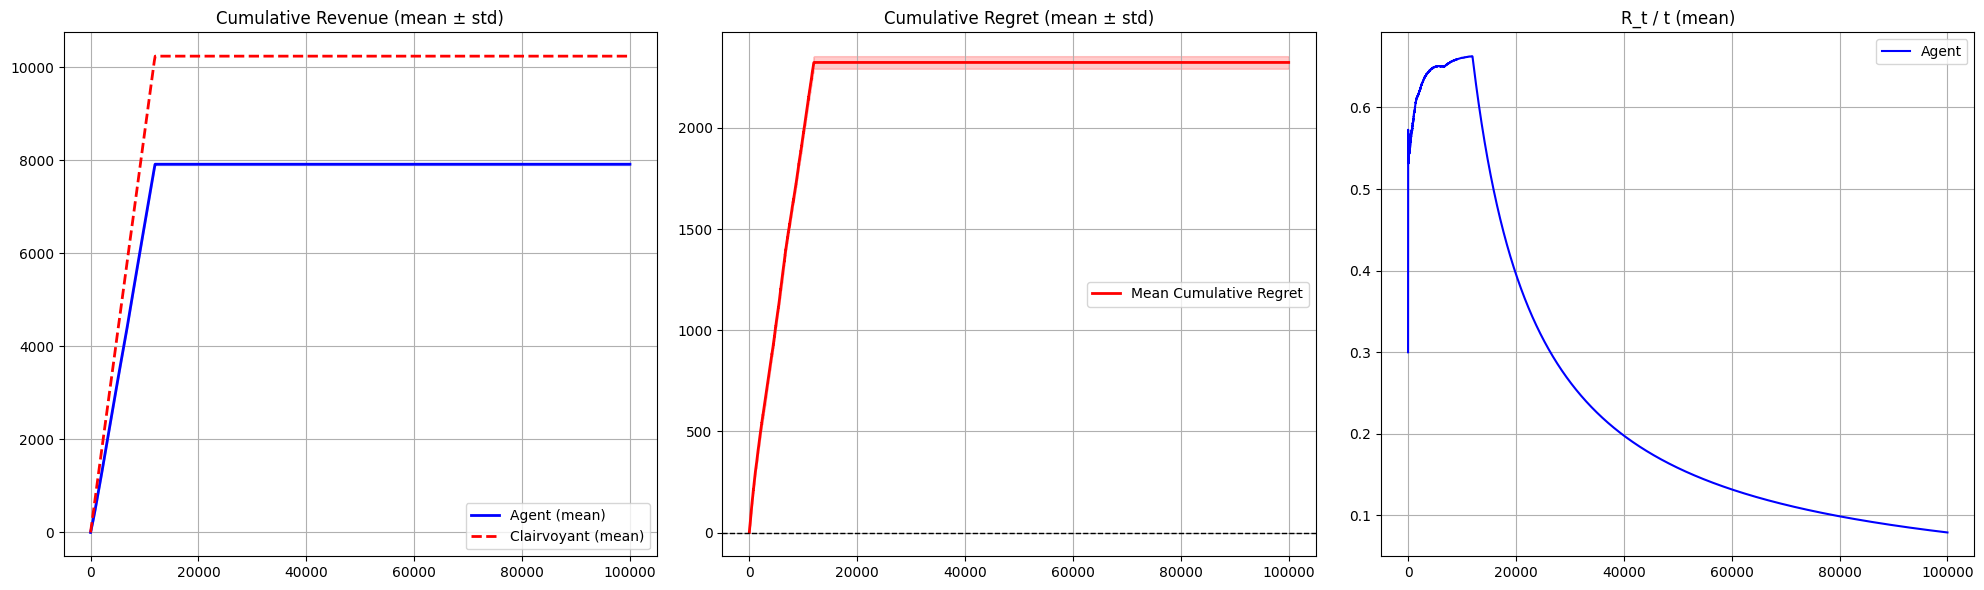


=== Final Performance Summary ===
Agent final revenue: 7916.42 ± 18.07
Clairvoyant final revenue: 10239.92 ± 37.08
Final regret: 2323.50 ± 31.11
Final regret %: 22.7%
Inventory utilization: 30000.0/30000 (100.0%)


In [13]:
# ----------------------------
# Run a multi-product pricing experiment
# ----------------------------

# Experiment parameters
N_SIMS = 5                # Number of simulation runs (increased for better statistics)
T = 100000                  # Number of rounds per simulation (reduced for faster testing)
N_PRODUCTS = 3            # Number of distinct types of products
PRICES_PER_PRODUCT = 7    # Number of discrete prices per product
INVENTORY_FRAC = 0.30     # Fraction of total rounds corresponding to inventory (reduced to make constraint binding)
ETA = 1.0 / np.sqrt(T)    # Learning rate for the dual variable update (increased for faster adaptation)
SEED = 202                # Base random seed

sims_results = []

for s in range(N_SIMS):
    print(f'Running sim {s+1}/{N_SIMS}...')

    # Run a single simulation
    res = run_one_simulation(T=T, n_products=N_PRODUCTS, prices_per_product=PRICES_PER_PRODUCT,
                             inventory_frac=INVENTORY_FRAC, eta=ETA, seed=SEED + s, lambda_init_mode='mid', algorithm='Exp3')
    
    # Compute the clairvoyant baseline (best fixed price per product)
    best_combo, clair_cum, method = compute_clairvoyant_smart(res['valuations_history'], res['price_grid_1d'], res['P'])
    
    # Store clairvoyant results in the simulation dictionary
    res['clairvoyant_combo'] = best_combo
    res['clairvoyant_cum'] = clair_cum
    res['clairvoyant_method'] = method

    # Append results for this run
    sims_results.append(res)
    
    # Print simulation summary
    print(f"Sim {s+1} completed:")
    print(f"  Agent total revenue: {res['total_revenue']:.2f}")
    print(f"  Clairvoyant total revenue: {clair_cum[-1]:.2f}")
    print(f"  Clairvoyant method: {method}")
    print(f"  Total regret: {clair_cum[-1] - res['total_revenue']:.2f}")
    print(f"  Inventory used: {res['P'] - res['agent'].remaining_inventory}/{res['P']}")
    if res['first_inventory_empty'] is not None:
        print(f"  Inventory depleted at round: {res['first_inventory_empty']}")
    print(f"  Clairvoyant optimal prices: {best_combo}")
    print()

print('All sims done.')

# Plot aggregated results across simulations
plot_results(sims_results, T)
